# Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα, ΣΗΜΜΥ ΕΜΠ, 2022-2023
Ομάδα 42
- Βαγγελάτος Οδυσσεύς (03118177)
- Γαλανόπουλος Νικόλαος (03118024)
- Νικολόπουλος Χρήστος (03118188)


# Τρίτη Εργασία: Βαθιά Μάθηση

Το παρόν notebook αποτελεί τροποποιημένη εκδοχή του tutorial [Image captioning with visual attention](https://www.tensorflow.org/tutorials/text/image_captioning). Ο κώδικας έχει αλλάξει σε διάφορα σημεία (πχ. συναρτήσεις [`prepare_dataset`](#scrollTo=4_Pt9zldjQ0q) και [`simple_gen`](#scrollTo=Nf1Jie9ef_Cg)), όπως και οι τιμές των παραμέτρων που εξετάζουμε, στις βέλτιστες. Επίσης, σε άλλα σημεία έχει προστεθεί κώδικας ([`create_captioner`](#scrollTo=SZDgB3o_nH8a), [`create_embedding_matrix`](#scrollTo=P6z6SS3Yiga2)). Η αναφορά των αποτελεσμάτων των δοκιμών μας και τα ανάλογα συμπεράσματα, βρίσκονται στο [τέλος του notebook](#scrollTo=Xo8IpZY8rgUX).

##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!echo
!pip uninstall -y tensorflow estimator keras
!echo
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!echo
!pip install einops

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This tutorial uses lots of imports, mostly for loading the dataset(s).

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

from google.colab import drive
import pprint

### Download & get train-test variables

In [ ]:
IMAGE_ZIP_FROM_DRIVE = False

In [ ]:
# DOWNLOAD IMAGES FOLDER

if not IMAGE_ZIP_FROM_DRIVE:
  # Download image files: Το TensorFlow χρησιμοποιεί το COCO, εμείς θέλουμε το flickr30k-images-ecemod.
  image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                        extract=True)
  os.remove(image_zip)

else:
  drive.mount('/content/drive')

  SHELL_PATH = "\"/content/drive/MyDrive/image_dir\""
  PATH = SHELL_PATH.replace('\"', '')

3129671680/4376381805 [====================>.........] - ETA: 1:47

Τα δεδομένα του flickr30k-images-ecemod είναι τα εξής:



*   φάκελος <font color="blue">`image_dir`</font>: 31.783 εικόνες από το Flickr
*   `captions_new.csv`: 148.915 captions για τις εικόνες του <font color="blue">`image_dir`</font>
*   `train_files.csv`: 21.000 εικόνες training set
*   `test_files.csv`: 4.524 εικόνων *test set*

In [ ]:
# DOWNLOAD CAPTIONS & TRAIN-TEST CSV MAPPINGS TO FILES

# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir = os.path.abspath('.'),
                                           origin = 'https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract = False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir = os.path.abspath('.'),
                                           origin = 'https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract = False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir = os.path.abspath('.'),
                                           origin = 'https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract = False)

In [ ]:
IMAGE_DIR="image_dir"
path = pathlib.Path('/content/drive/MyDrive' if IMAGE_ZIP_FROM_DRIVE else '.') # When image_dir comes from Google Drive

captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)

train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
# Examples
print("Variable train_captions:")
print("- Type:", type(train_captions))
print("- Just 3 items:")
print(*train_captions[:3], sep="\n")

print()

print("Variable train_raw:")
print("- Type:", train_raw.element_spec)
print("- Just 3 items:")
i = 0
for x, y in train_raw:  # batch(3).take(1)
  print(x)
  print(y)
  i += 1
  if i >= 3:
    break

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print("Example path:")
  print(ex_path)
  print()
  print("Its captions:")
  print(ex_captions)

### Image feature extractor

You will use an image model (**pretrained** on imagenet) **to extract the features from each image**. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


Για περισσότερες λεπτομέρειες ως προς την επιλογή του encoder, παραπέμπουμε στην ενότητα [Τελική Βελτιστοποίηση](#scrollTo=X3vGpCaS9qz0).

In [ ]:
IMAGE_SHAPE=(224, 224, 3)

# Make sure to choose the corresponding captioner architecture, depending on the encoder you chose.

# DEFAULT CHOICE:
# mobilenet = tf.keras.applications.MobileNetV3Small( 
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     include_preprocessing=True)

# "Optimal" (but slow) encoder
# mobilenet = tf.keras.applications.ConvNeXtBase( 
#     input_shape=IMAGE_SHAPE,
#     include_top=False)

# EfficientNetB0 (Decent Choice)
mobilenet = tf.keras.applications.EfficientNetB0( 
    input_shape=IMAGE_SHAPE,
    include_top=False)

mobilenet.trainable=False

Here's a function to load an image and resize it for the model:

In [ ]:
# Returns image as (224, 224, 3) tensor.
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :] # `ex_path` from previous for loop (bad practice!)
print("Input image (id?, width, height, RGB) shape:")
print(test_img_batch.shape)

print()

print("Output of image feature extractor/Feature map (id?, x1, x2, x3) shape:")
print(mobilenet(test_img_batch).shape)

### Setup the text tokenizer/vectorizer

You will transform the **text captions into integer sequences** using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* *Tokenize* all captions by <u>mapping each word to its **index in the vocabulary**</u>. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# We iterate all the train captions and produce a vocabulary that 
# consists of the top 10000 (5000 originally) words.

In [ ]:
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens = vocabulary_size,
    standardize = standardize,
    ragged = True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp, txt: txt).unbatch().batch(1024))

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

#### Example (tokenizer)

In [ ]:
tokenizer.get_vocabulary()[:10]

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']]) # Or equivalently: t = tokenizer(['a cat in a hat', 'a robot dog'])
t

In [ ]:
w = index_to_word(t)
w.to_list()

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are **1:1 images** to captions:

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
# EXAMPLE

print("Example: first 32 elements as 1:1")

for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print()

print('image paths size:', ex_paths.shape)
print('captions size:', ex_captions.shape)

print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths size AFTER:', ex_paths.shape)
print('captions size AFTER:', ex_captions.shape)

To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. <u>For text generation the tokens are both an input and the labels, shifted by one step</u>. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [ ]:
max_length, min_length = 33, 6

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .ignore_errors()
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE) # Ragged Tensor
          .unbatch()
          .filter(lambda _, token: min_length <= len(token) <= max_length) # Keep samples with captions in a chosen length range.
          .batch(batch_size)
          .map(to_tensor, tf.data.AUTOTUNE) # Padded Tensor
          .ignore_errors())

You could install the feature extractor in your model and train on the datasets like this:

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

### [Optional] Cache the image features

Since <u>the image feature extractor is not changing</u>, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [ ]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .ignore_errors()
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .filter(lambda _, token: min_length <= len(token) <= max_length) # Keep samples with captions in a chosen length range.
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
# Takes a lot of time 
# save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
# save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
# train_ds = load_dataset('train_cache')
# test_ds = load_dataset('test_cache')

In [ ]:
train_ds.element_spec

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim = max_length, output_dim = depth)
    
    self.token_embedding = tf.keras.layers.Embedding(
        input_dim = vocab_size,
        output_dim = depth,
        mask_zero = True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)
    
    # Produce the position embeddings for one of the sequences.
    # Broadcast the said embeddings to all the token embeddings.
    # The final embeddings are the sum of positional + token embeddings.
    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

#### CausalSelfAttention

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x, use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

#### CrossAttention 

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

#### FeedForward

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

#### DecoderLayer

Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(units = tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = np.zeros(shape = (self.tokenizer.vocabulary_size(), )) # self.bias was initially set to None.

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape = (self.tokenizer.vocabulary_size(), ))
    counts_arr[np.array(list(counts.keys()), dtype = np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

The smart initialization will significantly reduce the initial loss:

In [ ]:
# output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# # This might run a little faster if the dataset didn't also have to load the image data.
# output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun
 
  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length = 50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor          # <-- 2.1) image ~ *Encoder*: Extract features from image                       | PRETRAINED
    self.tokenizer = tokenizer                          # <-tokenize (later remains unused, because call() USES GLOBAL tokenizer instead of self! ~> bad?)
    self.word_to_index = tf.keras.layers.StringLookup(  # <-- 1)   USED TO translate [START] and push, to start captioning
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(  # <-- 3)   USED TO Translate generated sequence of indexes to sentence
        mask_token = "",
        vocabulary = tokenizer.get_vocabulary(),
        invert = True) 

    self.seq_embedding = SeqEmbedding(                  # <-- 2.2) text ~ Get token's embedding and positional encoding                 |  T-r-a-i-n-a-b-l-e ? y
        vocab_size = tokenizer.vocabulary_size(),
        depth = units,
        max_length = max_length)

    self.decoder_layers = [                             # <-- 2.3) *Decoder*(image, text)                                               |  T-r-a-i-n-a-b-l-e ? y
        DecoderLayer(units, num_heads = num_heads, dropout_rate = dropout_rate) # each contains self_attention, cross_attention & NN layer
        for n in range(num_layers)]

    self.output_layer = output_layer                    # <-- 2.4) *Decoder*'                                                           |  T-r-a-i-n-a-b-l-e ? y

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image. AGAIN???? 
      # Maybe this is a quick and dirty way to distinct between the case where 
      # someone calls the model by providing an RGB image VS the case where 
      # someone provides precomputed image features?
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

<br>

In [ ]:
import gensim.downloader as api

In [ ]:
def create_embedding_matrix(pretrained_embeddings):
  num_tokens = vocabulary_size
  embedding_dim = pretrained_embeddings.vector_size
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for idx, token in enumerate(tokenizer.get_vocabulary()):
      try:
          # Words not found in the embedding index will be all-zeros.
          embedding_matrix[idx] = pretrained_embeddings[token]
          hits += 1
      except KeyError:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [ ]:
def create_captioner(units = 256, dropout_rate = 0.5, num_layers = 2, num_heads = 2, max_length = max_length, embeddings = None):
  units = embeddings.vector_size if embeddings is not None else units
  output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
  output_layer.adapt(train_ds.map(lambda inputs, labels: labels)) # Must reinitialize in case the new embeddings have different dimensions.
  model = Captioner(tokenizer, feature_extractor = mobilenet, output_layer = output_layer,
                    units = units, dropout_rate = dropout_rate, num_layers = num_layers, 
                    num_heads = num_heads, max_length = max_length)
    
  if embeddings is not None:
    print("Loading the pretrained embedding matrix...")
    embedding_matrix = create_embedding_matrix(embeddings)
    model.seq_embedding.token_embedding = tf.keras.layers.Embedding(vocabulary_size, units, 
                                                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                                    trainable = False)
  return model

In [ ]:
wiki_300 = api.load('glove-wiki-gigaword-300')

In [ ]:
# Default Captioner
# model = create_captioner()

In [ ]:
# Captioner for ConvNeXtBase
# model = create_captioner(dropout_rate = 0.3, num_heads = 2, num_layers = 2, embeddings = wiki_300)

In [ ]:
# Captioner for the EfficientNetB0
model = create_captioner(dropout_rate = 0.3, num_heads = 2, num_layers = 4, embeddings = wiki_300)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature = 1, beam_search = False, beam_width = 3, max_length = max_length):
  initial = self.word_to_index([['[START]']])     # = (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])
  tokens = initial                                # = (batch, sequence)
  next_logits = lambda tokens: self((img_features, tokens)).numpy()[:, -1, :][0]

  if beam_search:
    # Modification based on the code of this article: https://blog.finxter.com/python-beam-search-algorithm/
    beta = beam_width
    completed_paths = list() # Stores the 'beta' best captions.
    ongoing_paths = [([token], logit) for token, logit in enumerate(next_logits(tokens))]
    ongoing_paths = sorted(ongoing_paths, key = lambda element: element[1], reverse = True)[:beta] # Stores the best incomplete captions.
    # At any given time |ongoing| + |completed| = beta.

    for _ in range(max_length - 1):
      extended_paths = list()
        
      # Follows each path.
      for tokens, logit in ongoing_paths:  # Reads the current paths and their length (sum of logits).
        next = enumerate(next_logits(tf.convert_to_tensor([tokens]))) 
        for j, conditional_logit in next: # We're extending each current path.
          extended_path = (tokens + [j], logit + conditional_logit)
          extended_paths.append(extended_path)
                
      # Sorts the newly extended paths by their length and keep the 'beta' best ones.
      extended_paths = sorted(extended_paths, key = lambda element: element[1], reverse = True)[:beta]
      
      new_ongoing = list()
      for candidate, logit in extended_paths:
        if candidate[-1] == self.word_to_index('[END]'):
          completed_paths.append((candidate, logit))
          beta -= 1
        else:
          new_ongoing.append((candidate, logit))
      ongoing_paths = new_ongoing.copy()

      if beta == 0: break

    completed_paths = completed_paths + ongoing_paths # All paths are completed. They either reached [END] or the maximum length. 
    tokens = sorted(completed_paths, key = lambda element: element[1] / len(element[0]), reverse = True)[0][0] # Keep the best caption
    tokens = tf.convert_to_tensor([tokens])
  else:
    for _ in range(max_length):
      preds = self((img_features, tokens)).numpy()  # = (batch, sequence, vocab). call(), "Pass `img_features` and `tokens` into the model"
      preds = preds[:,-1, :]  #(batch, vocab)

      if temperature == 0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
      else:
          next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

      if next[0] == self.word_to_index('[END]'):
        break
  
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature = t)
  print(result)

The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match * mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature = t)
      print(result)
    print()

It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [ ]:
callbacks = [
    #GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience = 5, restore_best_weights = True)]

### Train

Configure and execute the training.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    epochs = 100,
    callbacks=callbacks)

Plot the loss and accuracy over the training run:

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
result = model.simple_gen(image, temperature = 1.0)
result

In [ ]:
plt.imshow(image/255.)

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

So here is where the model was focusing attention while generating each token of the output:

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0, beam_search = False, beam_width = 3):
  result_txt = self.simple_gen(image, temperature = temperature, 
                               beam_search = beam_search, beam_width = beam_width)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

In [ ]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image, temperature = 0.0)

# Αναφορά Αποτελεσμάτων

## BLEU Evaluation

Χρησιμοποιούμε τo Sentence BLEU και κυρίως το Corpus BLEU ως τις μετρικές αξιολόγησης των αποτελεσμάτων μας, με βάση τις οποίες "βελτιστοποιούμε" το μοντέλο μας.

Ερμηνεία του (ποσοστιαίου) BLEU Score

| BLEU Score (%)|                       Interpretation                      |
|:-------------:|:---------------------------------------------------------:|
| < 10          | Almost useless                                            |
| 10 - 19       | Hard to get the gist                                      |
| 20 - 29       | The gist is clear, but has significant grammatical errors |
| 30 - 40       | Understandable to good translations                       |
| 40 - 50       | High quality translations                                 |
| 50 - 60       | Very high quality, adequate, and fluent translations      |
| > 60          | Quality often better than human                           |

([Source](https://cloud.google.com/translate/automl/docs/evaluate))

<br>

In [ ]:
import nltk.translate.bleu_score as bleu

In [ ]:
# Computes the Sentence BLEU of a given sample.
def evaluate_sample(t_caption, temperature = 1.0, beam_search = False, beam_width = 10):
  image_path, t_references = t_caption
  image = load_image(image_path)
  caption = model.simple_gen(image, temperature = temperature, 
                             beam_search = beam_search, beam_width = beam_width)
  split_references = map(lambda x: x.split(), t_references) # Split to words list.
  references = list(map(lambda x: x[:-1] if x[-1] == '.' else x, split_references)) # Remove '.': x[-1] check is needed, since usually the 3rd ref caption has no '.' 
  hypothesis = caption.split()
  score = bleu.sentence_bleu(references, hypothesis,
                             weights = (0.4, 0.3, 0.2, 0.1),
                             smoothing_function = bleu.SmoothingFunction().method1)

  plt.imshow(image / 255.)
  print(f"Hypothesis:\t{caption}")
  print(f"References:\n{t_references}")
  print(f"Sentence Bleu:\t{100 * score:.3f}%")

In [ ]:
# Computes the Corpus BLEU of stop - start + 1 consecutive samples.
def generate_corpus_bleu(t_captions, start, stop, temperature = 1.0, beam_search = False, beam_width = 10): # upper limit included
  list_of_references, hypotheses = list(), list()
  for (image_path, t_references) in t_captions[start:stop+1]:
    image = load_image(image_path)
    caption = model.simple_gen(image, temperature = temperature, 
                               beam_search = beam_search, beam_width = beam_width)
    split_references = map(lambda x: x.split(), t_references)
    filtered_references = list(map(lambda x: x[:-1] if x[-1] == '.' else x, split_references))
    list_of_references.append(filtered_references)

    hypotheses.append(caption.split())
  
  return bleu.corpus_bleu(list_of_references, hypotheses, 
                          weights = (0.4, 0.3, 0.2, 0.1),
                          smoothing_function = bleu.SmoothingFunction().method1)

<br>

In [ ]:
lower, upper = 1500, 1600

In [ ]:
# Decode a consecutive section of a dataset with the two best widths.
# Compute the corresponding Corpus BLEU score.

In [ ]:
for beam_width in [3, 5]:
  print("beam_width=", beam_width, end=" -> ")
  start = time.time()
  print(f"{100 * generate_corpus_bleu(test_captions, lower, upper, temperature = 0, beam_search = True, beam_width = beam_width):.3f}%", end=", ")
  print(f"Time elapsed: {time.time() - start}")

In [ ]:
# Decode a consecutive section of a dataset for various temperatures.
# Compute the corresponding Corpus BLEU score.

In [ ]:
for t in [0, 0.5, 1]:
  print(f"{100 * generate_corpus_bleu(test_captions, lower, upper, temperature = t):.3f}%")

<br>

In [ ]:
# evaluate_sample usage example

In [ ]:
%%time
idx = 1800
ex_bleu = evaluate_sample(test_captions[idx], temperature = 0, beam_search = True, beam_width = 3)

In [ ]:
# Some test_caption ids:
# 888 -> couple
# 1999 -> ακορντεόν
# 1099 -> store
# 1899 -> motorbike

## Απόδοση Default Μοντέλου

<u> *Παράμετροι:* </u>
- 100 Epochs, Patience: 5 Epoches, 200 steps per epoch, 30 Validation steps.
- Vocabulary size: 5000, `max_length = 50`, Feature Extractor: MobileNetV3Small

Το default μοντέλο συνέκλινε μετά από 51 εποχές. Training Loss ~ 3.39, Validation Loss ~ 3.35, Masked Accuracies both around 0.356. (Οι τιμές του παραπάνω κελιού δεν αντιστοιχούν ακριβώς στο βέλτιστο μοντέλο, λόγω χρήσης checkpoints)

```
Epoch 51/200 100/100 [==============================] - 13s 134ms/step - loss: 3.3892 - masked_acc: 0.3567 - val_loss: 3.3446 - val_masked_acc: 0.3550
```
*Logs του τελευταίου epoch της εκπαίδευσης*

<br>

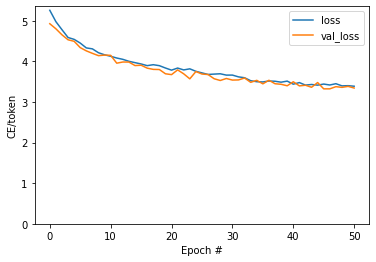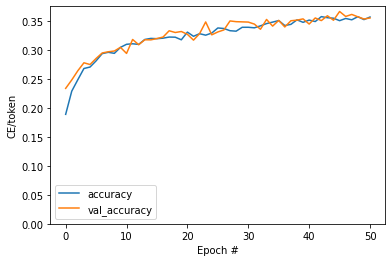

*Loss & Accuracy του default μοντέλου*

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 20.339% (`t = 0`)
2. 16.718% (`t = 0.5`)
3. 3.574%  (`t = 1`)

Τα παρακάτω παραδείγματα έχουν προκύψει από greedy decoding.

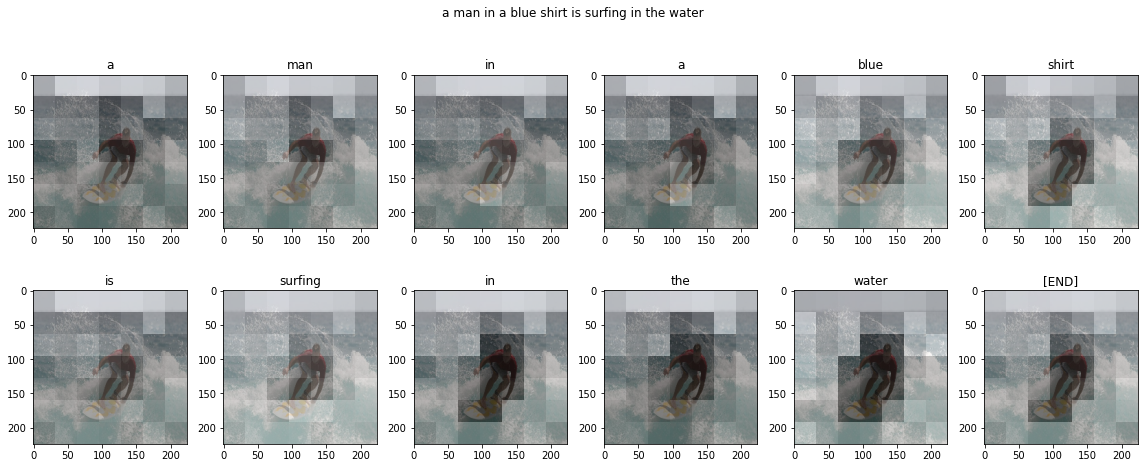

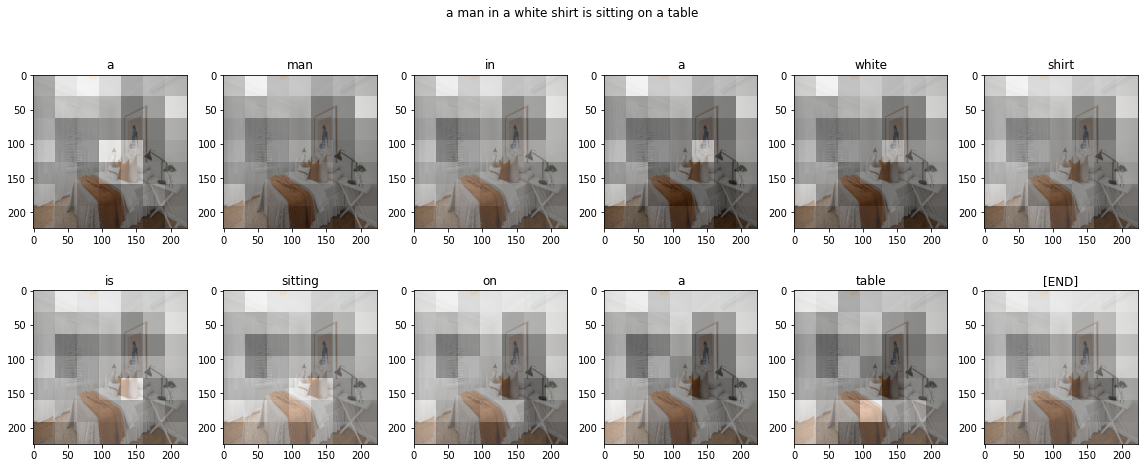

Το πρώτο είναι σχετικώς επιτυχημένο, πέρα από το λάθος χρώμα στη μπλούζα του σέρφερ. Η δεύτερη εικόνα που σαφώς είναι πιο σύνθετη, δεν περιγράφεται ικανοποιητικά από το μοντέλο μας.

## Βελτιστοποίηση

Η εκπαίδευση κάθε μοντέλου είναι υπερβολικά αργή, ενώ καλούμαστε να βελτιστοποιήσουμε 10 παραμέτρους (`encoder`, `min_length`, `max_length`, `vocabulary_size`, `embeddings`, `beam_width`, `units`, `dropout_rate`, `num_heads`, `num_layers`), οπότε δεν χρησιμοποιούμε ως μέθοδο βελτιστοποίησης τεχνική, όπως το Grid Search. Δοκιμάζουμε τιμές και μέσω παρατηρήσεων ανανεώνουμε την εκτίμηση των βέλτιστων παραμέτρων ή καταλήγουμε σε παράμετρο που θεωρούμε βέλτιστη. 

Προτού καταλήξουμε σε encoder, δοκιμάσαμε ευριστικά να βελτιστοποιήσουμε το preprocessing του κειμένου, τα pretrained embeddings, το `beam_width` και το `dropout_rate`.  Κάθε παράμετρο, την εξετάζουμε αλλάζοντας το default μοντέλο και κρατώντας όλες τις άλλες παραμέτρους στις προκαθορισμένες τιμές τους.

### Πρώτη Βελτιστοποίηση

#### Προεπεξεργασία Κειμένου

##### Μήκη των captions

Για το `min_length` & `max_length` τροποποιήσαμε τη `prepare_dataset` προσθέτοντας τις εξής γραμμές κώδικα:
```
.unbatch()
.filter(lambda _, token: min_length <= len(token) <= max_length)
.batch(batch_size)
```
Έτσι, φροντίζουμε να κρατάμε τα δείγματα που έχουν captions με tokens στο κατάλληλο range. (Φιλτράρουμε τα δείγματα, αφού έχει γίνει το redundant replication των εικόνων, ώστε να έχουμε δείγματα μορφής `(img, caption)`.)

Σχεδιάζουμε ιστόγραμμα των lengths (σε tokens) των δειγμάτων εκπαίδευσης:

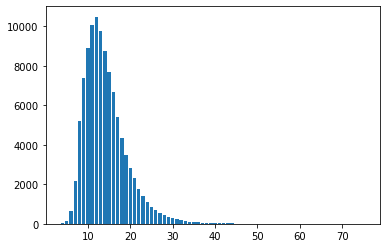

Πιο αναλυτικά:

```
length, no. of captions
(4, 16), (5, 148), (6, 636), (7, 2179), (8, 5214), (9, 7364), (10, 8913), (11, 10044), (12, 10489), (13, 9788), (14, 8759), (15, 7713), (16, 6672), (17, 5432), (18, 4353), (19, 3491), (20, 2804), (21, 2306), (22, 1765), (23, 1393), (24, 1085), (25, 866), (26, 690), (27, 562), (28, 431), (29, 344), (30, 271), (31, 236), (32, 198), (33, 144), (34, 110), (35, 96), (36, 101), (37, 59), (38, 48), (39, 48), (40, 33), (41, 40), (42, 23), (43, 20), (44, 19), (45, 9), (46, 13),
 (47, 3), (48, 11), (49, 8), (50, 6), (51, 8), (52, 6), (53, 7), (54, 2), (55, 2), (56, 4), (57, 5), (59, 2), (60, 1), (61, 1), (62, 1), (64, 2), (65, 2), (67, 1), (70, 1), (72, 1),(75, 1)
```



Δεν προβαίνουμε σε εξονυχιστική βελτιστοποίηση των `min_length` & `max_length`. Παρατηρούμε πως έχουμε πολύ λίγα captions με μήκος γνήσια μικρότερο από 6. Επίσης, δεν θέλουμε να εκπαιδεύσουμε το δίκτυο μας με εκτενείς περιγραφές αν δεν είναι αναγκαίο. Αποφασίζουμε να απορρίψουμε τα δείγματα με `max_length` γνήσια μεγαλύτερο του 33. Με αυτά τα δύο όρια, αφαιρούμε ακριβώς 1000 δείγματα από το training dataset το οποίο σαφώς αποτελεί πολύ μικρό ποσοστό επί του αρχικού dataset.
 
Άρα καταλήγουμε σε `min_length = 6` και `max_length = 33`.

Παρακάτω παραθέτουμε τον κώδικα με τον οποίο δημιουργήσαμε το ιστόγραμμα των μηκών των captions. Ο κώδικας είναι πρόχειρος και αργός, δεν συστείνουμε να τον επανεκτελέσετε.

In [ ]:
# Too slow (took 7 minutes). Ran it once and simply kept the results in markdown.
# hist = {}
# for (_, ex_captions) in train_captions:
#     lengths = map(len, tokenizer(ex_captions))
#     for length in lengths:
#       if length in hist: hist[length] += 1
#       else: hist[length] = 1
# plt.bar(hist.keys(), hist.values())

##### Μέγεθος Λεξιλογίου

Η βελτιστοποίηση του `vocabulary_size` έγινε με τον εξής τρόπο: Αλλαγή της μεταβλητής, εκπαίδευση του δικτύου και εμφάνιση και αξιολόγηση των captions για τυχαίες εικόνες του test_set. Έχουμε τα εξής αποτελέσματα για κάθε μέγεθος λεξιλογίου:
- $5κ=5000$: Η default επιλογή. Χρησιμοποιείται ως βάση σύγκρισης.
- $7κ$: Δεν παρατηρείται καμία αισθητή διαφορά, ακόμη εμφανίζονται πολλές φορές η λέξη "shirt" και "building".
- $10κ$: Ελαφρώς καλύτερο από το $20κ$.
- $15κ$: Κακή επίδοση, μεγάλες προτάσεις.
- $20κ$: Μεγαλύτερη λεπτομέρεια στην παραγωγή captions, καθώς δίνει πολλές φορές ακριβώς τη λέξη του αντικειμένου που δείχνει η εικόνα. Συνεπώς, φαίνεται πολλά υποσχόμενο. Δυστυχώς, χάνει τα πιο σημαντικά σημεία της εικόνας αλλά εντοπίζει τα λοιπά πράγματα καλά. Για παράδειγμα, σε εικόνα που δείχνει δύο παιδιά να κάθονται σε μία πολυθρόνα και να κρατούν ένα μωρό, ενώ το μωρό καλύπτει σχεδόν το μισό την εικόνας, παράγεται caption του τύπου "Δύο παιδιά κάθονται σε έναν καναπέ".
- $30κ$: Καμία αισθητή βελτίωση σε σχέση με το $20κ$, ίσως ελαφρώς χειρότερο, διότι δεν πιάνει σωστά τα χρώματα των t-shirts και λέει σε πολλές εικόνες τη φράση "group of people", ενώ μπορεί να μην ισχύει.


Ξεχωρίζουμε τα μεγέθη $5κ, 10κ, 20κ$. Υπολογίζουμε με beam search, το Corpus BLEU για τα widths που θεωρούμε ως βέλτιστα, για τις εικονές 1500-1600.

- $5κ$
```
beam_width= 3 -> 14.495%, Time elapsed: 661.3847734928131
beam_width= 5 -> 17.721%, Time elapsed: 1001.6210522651672
```

- $10κ$
```
beam_width= 3 -> 20.044%, Time elapsed: 567.0277767181396
beam_width= 5 -> 21.345%, Time elapsed: 941.8201951980591
```

- $20k$
```
beam_width= 3 -> 20.012%, Time elapsed: 853.4685924053192
beam_width= 5 -> 20.906%, Time elapsed: 1337.142323255539
```


Αχρείαστα μεγάλο λεξιλόγιο, οδηγεί σε κοστοβόρο beam search, επειδή αυξάνεται το πλήθος των logits που πρέπει να εξετάζουμε σε κάθε βήμα. Αντίθετα, πολύ μικρό λεξιλόγιο, περιορίζει την εκφραστικότητα του μοντέλου. Eπιλέγουμε `vocabulary_size=10000`, τόσο λόγω χρόνου αποκωδικοποίησης όσο και του Corpus BLEU.

##### Φίλτρα Κανονικοποίησης

Τα φίλτρα κανονικοποίησης που γνωρίζουμε αφορούν την αφαίρεση στίξεως (κάτι που ήδη πραγματοποιεί ο τρέχον κώδικας) και ειδικών χαρακτήρων, τη μετατροπή σε πεζά (που επίσης πραγματοποιεί), την αφαίρεση κοινών λέξεων (stopwords) και ονομάτων και τα stemming & lemmatization. Δεν προσθέτουμε κάποιο επιπλέον φίλτρο κανονικοποίησης, που να μην περιλαμβάνεται στον αρχικό κώδικα. 

Δεν θέλουμε να κάνουμε stemming/lemmatization. Θέλουμε το μοντέλο μας να είναι σε θέση να παράγει γραμματικά σωστές προτάσεις. Για να το πετύχει αυτό, πρέπει να κρατήσουμε στην αρχική τους μορφή τα ρήματα και τα ουσιαστικά. πχ. αν με lemmatization οι λέξεις "plays", "player" κοκ. γίνουν όλες "play" στο training set, τότε θα είναι ουσιαστικά αδύνατο το μοντέλο μας να χρησιμοποιήσει τις λέξεις αυτές για τη παραγωγή caption. (αυτό αποτελεί πιο πολύ σκέψη και όχι πραγματικό case από το dataset μας) 

Αντίστοιχα, δεν θέλουμε να αφαιρεθούν τα stopwords, ώστε να μπορούν να χρησιμοποιούνται στα παραγόμενα captions. (Δύσκολο να παραχθούν "φυσιολογικά" captions χωρίς λέξεις όπως "the", "is", "a" κλπ.)

#### Pretrained Embeddings

Για την εισαγωγή των pretrained embeddings, χρησιμοποιήσαμε το εξής [tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/). Ουσιαστικά δημιουργούμε έναν numpy πίνακα μεγέθους `vocabulary_size x embeddings dimension` και σε κάθε γραμμή του βάζουμε το pretrained embedding που αντιστοιχεί στο i-οστό token. Τον χρησιμοποιούμε ως embeddings matrix, για να αρχικοποιήσουμε το embeddings layers του μοντέλου μας. Σαφώς, κάνουμε non-trainable το layer αυτό. Δεν έχουμε στόχο να κάνουμε fine-tuning των embeddings, αλλά απλούστερο transfer learning.

***Σημείωση 1***: Έτσι όπως έχει υλοποιηθεί η παραπάνω αρχιτεκτονική, η διάσταση των word embeddings οφείλει να είναι ίση με το πλήθος των units. Επιλέξαμε να μην κάνουμε padding των embeddings, άρα να μην έχουμε "ελευθερία" στο πλήθος των units, όταν χρησιμοποιούμε pre-trained embeddings. Συνεπώς, παραπάνω, τα διάφορα embeddings δεν θα επηρεάζουν την επίδοση του μοντέλου μόνο λόγω "διαφορετικής ποιότητάς" τους, αλλά και του διαφορετικού πλήθους από units που επιβάλλουν. Αυτή σαφώς δεν είναι η καλύτερη μέθοδος αξιολόγησής τους.

***Σημείωση 2***: Όπως έχουμε υλοποιήσει τα embeddings, το token `[START]` μάλλον δεν συμπεριλαμβάνεται στα pretrained embeddings. Σε όλα τα άγνωστα tokens, έχουμε ως embedding το μηδενικό διάνυσμα. Αυτό ίσως να κάνει χειρότερο το decoding επειδή υπάρχουν tokens που έχουν κοινό embedding, σε αντίθεση με τα non-pretrained.

##### Wiki 50

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 4.626% (`t = 0`)
2. 7.975% (`t = 0.5`)
3. 2.878%  (`t = 1`)

Τα παρακάτω παραδείγματα έχουν προκύψει από greedy decoding.

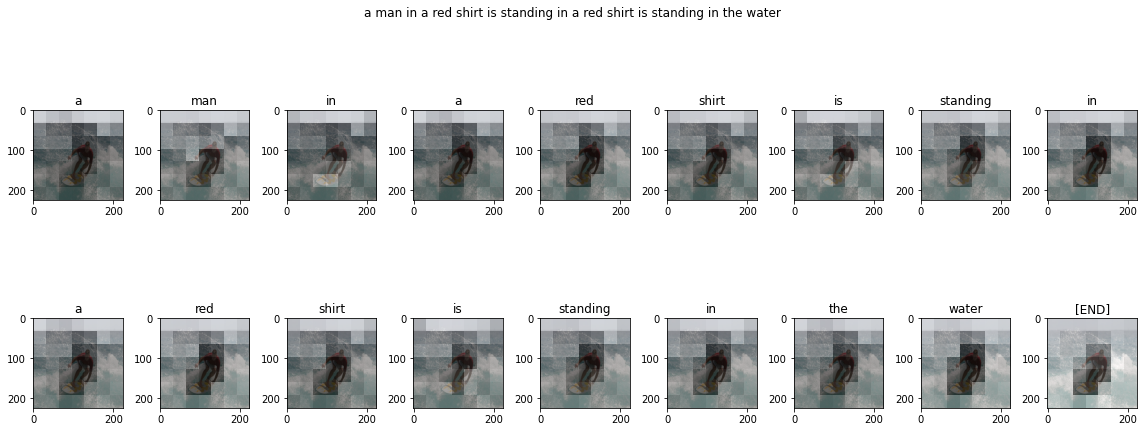

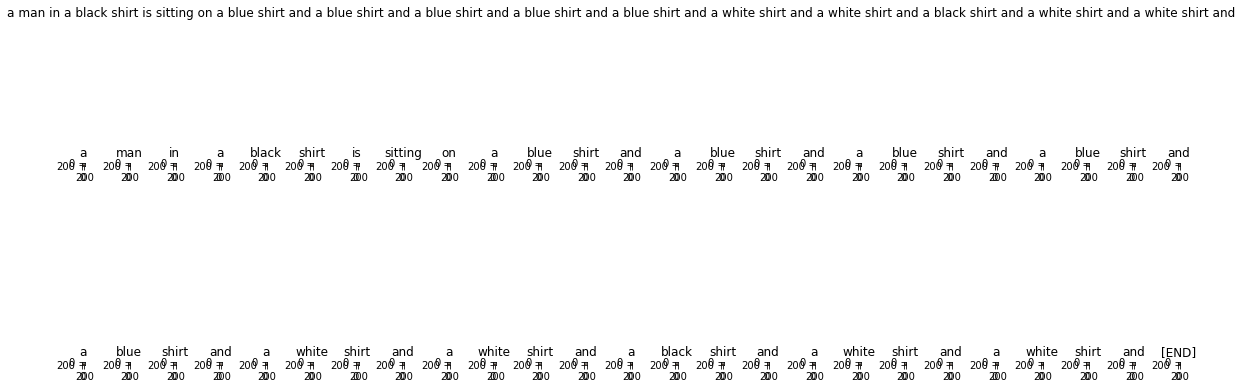

##### Wiki 100

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 17.396% (`t = 0`)
2. 14.508% (`t = 0.5`)
3. 4.956%  (`t = 1`)

Τα παρακάτω παραδείγματα έχουν προκύψει από greedy decoding.

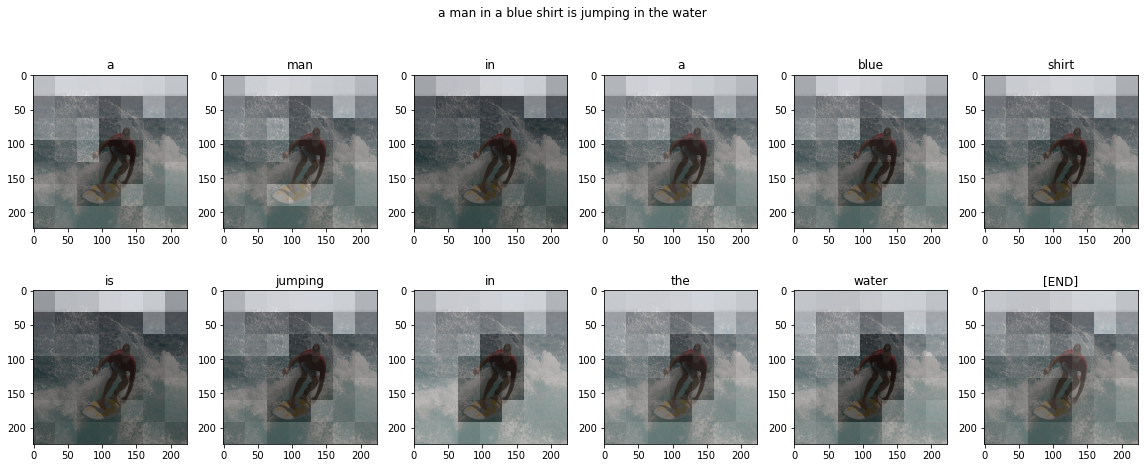

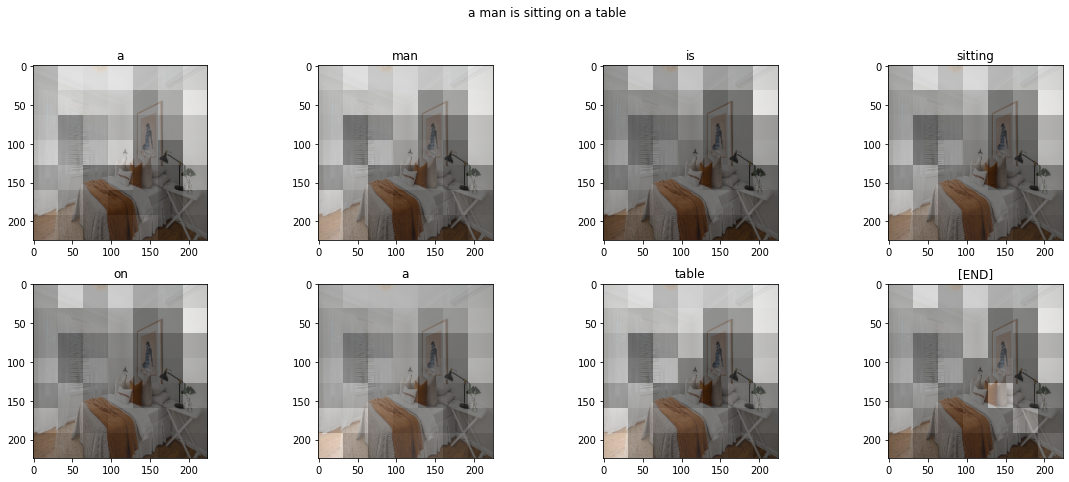

##### Wiki 200

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 13.820% (`t = 0`)
2. 15.985% (`t = 0.5`)
3. 6.325%  (`t = 1`)

Τα παρακάτω παραδείγματα έχουν προκύψει από greedy decoding.

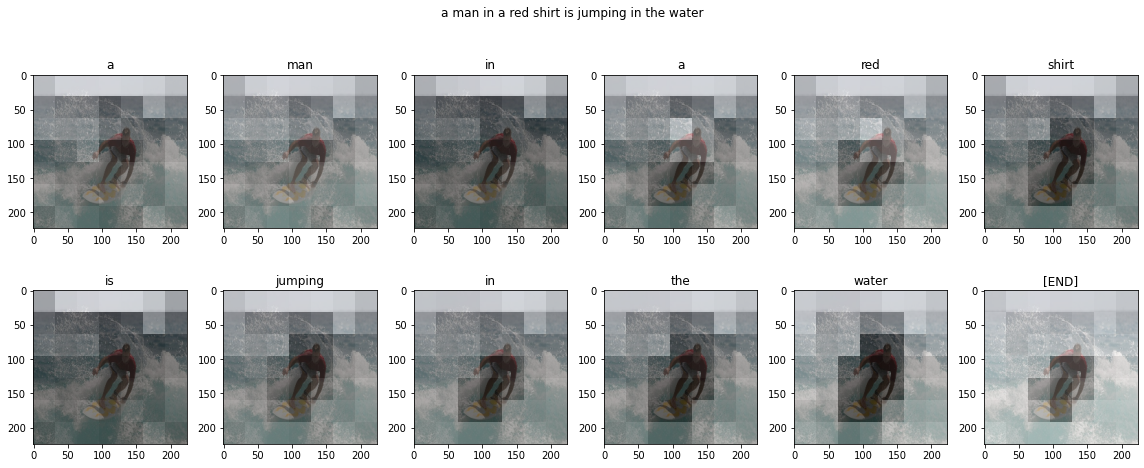

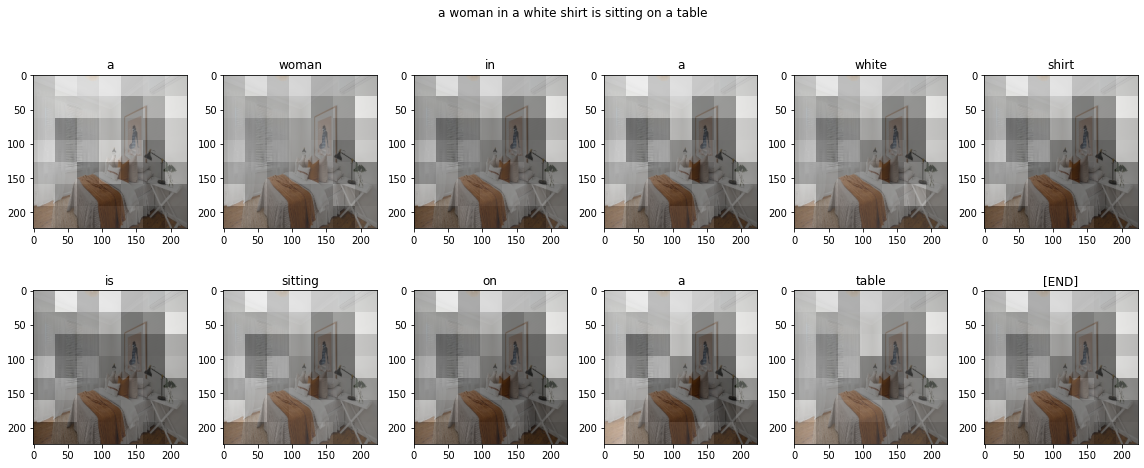

##### Wiki 300

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 22.359% (`t = 0`)
2. 21.140% (`t = 0.5`)
3. 8.073%  (`t = 1`)

Τα παρακάτω παραδείγματα έχουν προκύψει από greedy decoding.

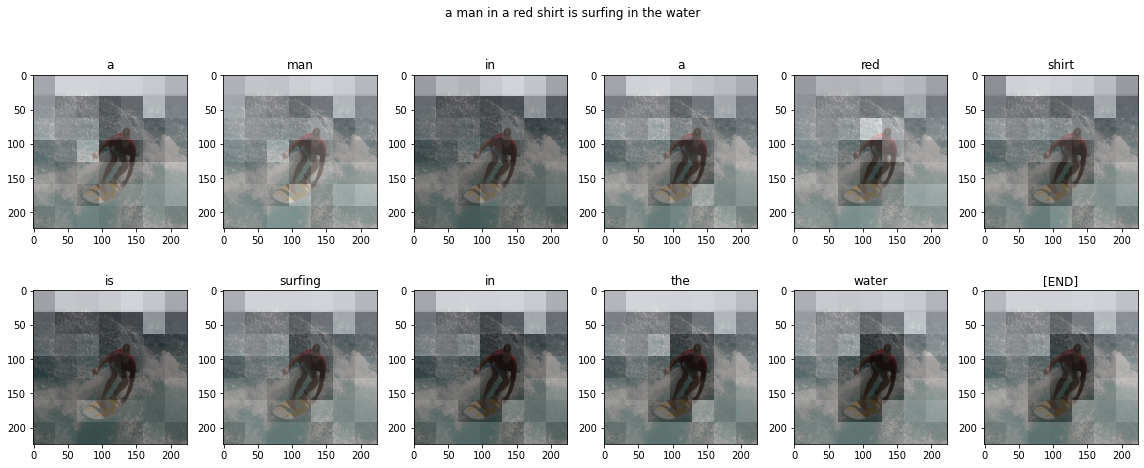

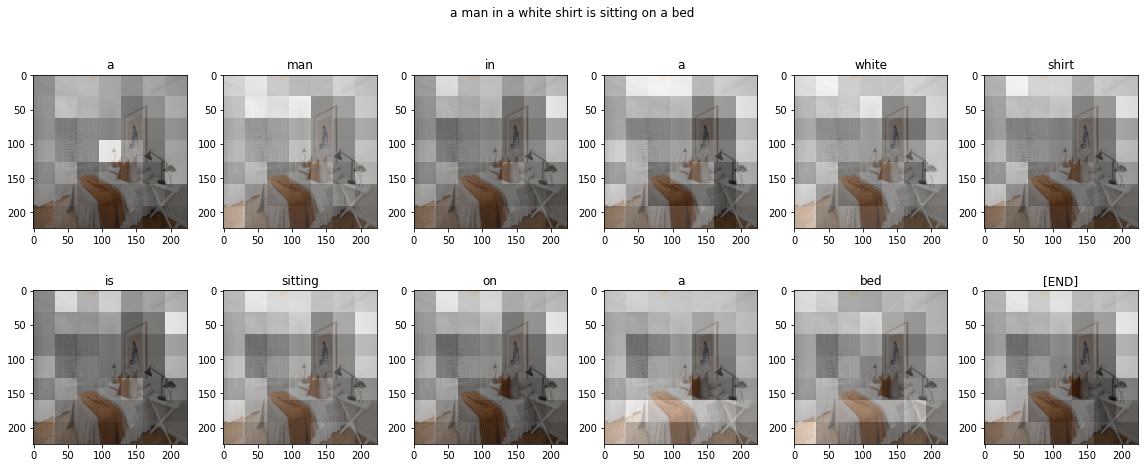

##### Παρατηρήσεις

Το `wiki300` αποδίδει σημαντικά καλύτερα όσον αφορά το Corpus BLEU για "χαμηλές" θερμοκρασίες. Για `t = 1` τα συμπεράσματα δεν είναι τελείως ξεκάθαρα, αφού έχει εισαχθεί τυχαιοτητα σε μεγάλο βαθμό στο decoding. 

Σίγουρα απορρίπτουμε το `wiki50`, τόσο λόγω του Corpus BLEU Score, όσο και των captions που παράγει στις δύο "άγνωστες εικονες" με greedy τρόπο. Καταλήγει να δημιουργεί μακροσκελείς ασυνάρτητες περιγραφές.

Το `wiki100` έχει υψηλότερα Corpus BLEU scores από το `wiki200`, όμως στις άγνωστες εικόνες, στο `wiki200`, τα αποτελέσματα είναι πιο επιτυχημένα (πχ. αναγνώριση κόκκινης μπλούζας στη πρώτη εικόνα, γυναίκας στη δεύτερη). Ενδεχομένως να είναι cherry picking, αλλά τονίζουμε τη δυσκολία ως προς την επιλογή των "καλύτερων" embeddings.

To `wiki300` σε γενικές γραμμές υπερτερεί των υπολοίπων όσον αφορά το Corpus BLEU σε "χαμηλές θερμοκρασίες", ενώ ερμηνεύει αρκετά καλά την εικόνα με τον surfer. Καταλήγουμε να επιλέξουμε αυτό ως "καλύτερο" pretrained embedding.

#### Sentence Generator


Για τη χρήση του Beam Search υλοποιήσαμε μόνοι μας τον αλγόριθμο, δηλαδή χωρίς τη φόρτωση βιβλιοθήκης, αυτό γιατί δε βρέθηκε κατάλληλη και εύχρηστη βιβλιοθήκη ή  συνάρτηση στο Tensorflow.

Ακολουθούν τα αποτελέσματα των δοκιμών για τη βελτιστοποίηση του `beam_width` (με `MobileNetV3Small` ως encoder). Επειδή αργεί η παραγωγή caption για πολλές εικόνες όταν η τιμή είναι μεγάλη, κρίνουμε την επίδοση κάθε τιμής του `beam_width` με βάση τυχαία μικρά υποσύνολα των εικόνων που δίνονται.

- Images 40,41,42,43:
```
beam_width= 1, 30.778%, Time elapsed: 7.856969356536865
beam_width= 2, 34.569%, Time elapsed: 7.667365789413452
beam_width= 3, 38.432%, Time elapsed: 14.264297723770142
beam_width= 4, 35.172%, Time elapsed: 18.52216601371765
beam_width= 5, 35.172%, Time elapsed: 23.47061276435852
beam_width= 6, 36.027%, Time elapsed: 27.290071964263916
beam_width= 7, 36.027%, Time elapsed: 31.786039113998413
beam_width= 8, 36.027%, Time elapsed: 35.269734144210815
beam_width= 9, 36.027%, Time elapsed: 43.35445690155029
beam_width= 10, 36.027%, Time elapsed: 45.71202206611633
beam_width= 11, 39.906%, Time elapsed: 53.272249937057495
beam_width= 12, 36.027%, Time elapsed: 53.56599140167236
beam_width= 13, 39.906%, Time elapsed: 63.03626036643982
beam_width= 14, 39.906%, Time elapsed: 69.3647952079773
beam_width= 15, 39.906%, Time elapsed: 71.56807971000671
beam_width= 16, 39.906%, Time elapsed: 76.99621510505676
beam_width= 17, 39.906%, Time elapsed: 84.65137457847595
beam_width= 18, 39.906%, Time elapsed: 87.26963520050049
beam_width= 19, 39.906%, Time elapsed: 91.44561314582825
beam_width= 20, 39.906%, Time elapsed: 96.60600543022156
```
Τα καλύτερα είναι `beam_width= 3, 38.432%`, `beam_width= 11, 39.906%`.

- Images κοντά στο 3000:
```
beam_width= 1 -> 21.688%, Time elapsed: 12.578108787536621
beam_width= 2 -> 19.242%, Time elapsed: 18.553985595703125
beam_width= 3 -> 21.066%, Time elapsed: 38.582457065582275
beam_width= 4 -> 22.469%, Time elapsed: 46.45797514915466
beam_width= 5 -> 22.871%, Time elapsed: 39.632166624069214
beam_width= 6 -> 22.368%, Time elapsed: 55.456687688827515
beam_width= 7 -> 22.368%, Time elapsed: 50.346349239349365
beam_width= 8 -> 22.368%, Time elapsed: 60.36378574371338
beam_width= 9 -> 22.368%, Time elapsed: 66.58147597312927
beam_width= 10 -> 9.552%, Time elapsed: 71.53358793258667
beam_width= 11 -> 22.368%, Time elapsed: 83.67789459228516
beam_width= 12 -> 22.368%, Time elapsed: 90.39104676246643
beam_width= 13 -> 22.246%, Time elapsed: 98.26688981056213
beam_width= 14 -> 8.886%, Time elapsed: 105.14200091362
beam_width= 15 -> . . .
```
Τα καλύτερα είναι `beam_width= 1 -> 21.688%`, `beam_width= 5 -> 22.871%`.

- Images 4440-4445:
```
beam_width= 1 -> 26.023%, Time elapsed: 8.989942789077759
beam_width= 3 -> 14.098%, Time elapsed: 20.26858925819397
beam_width= 5 -> 17.188%, Time elapsed: 35.00991702079773
beam_width= 10 -> 13.666%, Time elapsed: 70.52146649360657
beam_width= 12 -> 13.044%, Time elapsed: 79.70551300048828
beam_width= 15 -> 13.044%, Time elapsed: 101.35650396347046
```
Τα καλύτερα είναι `beam_width= 1 -> 26.023%`, `beam_width= 5 -> 17.188%`.


- Images 2666-2670:
  - Με `vocab_size`=$5κ$: 
```
beam_width= 1 -> 18.782%, Time elapsed: 7.328875780105591
beam_width= 3 -> 25.424%, Time elapsed: 18.048911333084106
beam_width= 5 -> 31.123%, Time elapsed: 29.73773455619812
beam_width= 10 -> 33.372%, Time elapsed: 64.99227976799011
beam_width= 12 -> 33.372%, Time elapsed: 79.65007209777832
beam_width= 15 -> 33.372%, Time elapsed: 94.6905472278595
```

  - Με `vocab_size`=$20κ$: 
```
beam_width= 1 -> 20.668%, Time elapsed: 13.843381404876709
beam_width= 3 -> 30.964%, Time elapsed: 38.10278034210205
beam_width= 5 -> 26.914%, Time elapsed: 73.11452794075012
beam_width= 10 -> 24.367%, Time elapsed: 113.51316547393799
beam_width= 12 -> . . .
```
  - Με `vocab_size`=$30κ$:
```
beam_width= 1 -> 12.478%, Time elapsed: 22.14791703224182
beam_width= 3 -> 34.265%, Time elapsed: 41.03533577919006
beam_width= 4 -> 26.326%, Time elapsed: 51.87099814414978
beam_width= 5 -> 26.343%, Time elapsed: 63.95036244392395
beam_width= 10 -> . . .
```

Παρακάτω υπολογίζουμε το Corpus BLEU σε υποσύνολο 100 εικόνων. Οι καθυστερήσεις στο decoding γίνονται ακόμη πιο εμφανείς.

- Images 1500-1600:
```
beam_width= 1 -> 10.069%, Time elapsed: 290.1142883300781
beam_width= 3 -> 14.495%, Time elapsed: 661.3847734928131
beam_width= 4 -> 15.603%, Time elapsed: 822.2780473232269
beam_width= 5 -> 17.721%, Time elapsed: 1001.6210522651672
beam_width= 10 -> 17.382%, Time elapsed: 1882.4650928974152
beam_width= 15 -> 17.214%, Time elapsed: 2702.906590461731
```


Με βάση τα παραπάνω επιλέγουμε `beam_width=3`. Δεν αξίζει μεγαλύτερο width (πχ το `5`) για τον *επιπλέον χρόνο* που παίρνει, επειδή παρατηρήσαμε πως παράγονται περισσότερες αχρείαστα μεγαλές προτάσεις που δε βγάζουν νοήμα. Αυτό προέκυψε ύστερα από μεμονομένες δοκιμές σε εικόνες. Εξάλλου, σε μία αληθινή εφαρμογή, μας ενδιαφέρει να παράγονται σε λογικό χρόνο τα captions, γι'αυτό και κρατάμε το width μικρό. 

*(Σε κάποιες περιπτώσεις, αξίζει να αφιερώσουμε περισσότερο χρόνο με `beam_width = 5` για την επίτευξη υψηλότερου Corpus BLEU Score, μεγαλύτερα widths αυξάνουν το χρόνο παραγωγής των captions.)*

Παρατηρoύμε ότι μπορεί το BLEU score να αυξάνεται αλλά το caption να μοιάζει ημιτελές και μεγάλο χωρίς λόγο.

Ακόμη βλέπουμε ότι με την αύξηση του beam width δεν αυξάνει μονότονα και το BLEU score, όπως κανείς θα περίμενε. Αντιθέτως, φτάνει μία μέγιστη τιμή και στη συνέχεια μειώνεται. Αυτό οφείλεται στο ότι οι πιθανότητες που έχει το μοντέλο για την επιλογή κάθε λέξης δεν είναι οι πραγματικές/ιδανικές.

#### Υπερπαράμετροι του decoder

Σε πρώτη φάση δοκιμάζουμε να βελτιστοποιήσουμε το dropout rate.

Το dropout αποτελεί μέθοδο regularization, δηλαδή τεχνικής που δεν έχει στόχο να βελτιστοποιήσει το training loss, αλλά το σφάλμα γενίκευσης.

Το dropout rate σε ένα σύνηθες πολυστρωματικό νευρωνικό, αποτελεί τη πιθανότητα με την οποία ένας νευρώνας συμμετέχει ή όχι στο τρέχον βήμα εκπαίδευσης του δικτύου.

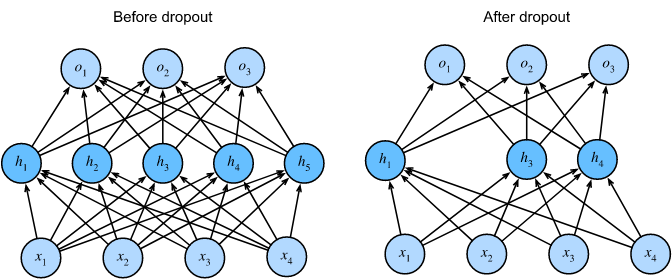

*Πηγή: https://d2l.ai/chapter_multilayer-perceptrons/dropout.html*

Άρα, αν ένα επίπεδο έχει dropout rate 0.6 και πχ. 10 νευρώνες, αναμένουμε 6 να είναι ανενεργοί.

Το σκεπτικό πίσω από αυτή τη τεχνική είναι κάθε νευρώνας να είναι "αυτάρκης". Να μπορεί να αποδίδει καλά ακόμη και αν γειτονικοί νευρώνες από τους οποίους εξαρτάται, δίνουν λάθος αποτελέσματα ή στην ακραία περίπτωση (όπως εδώ), είναι τελείως ανενεργοί. Σαφώς δεν είναι καλή ιδέα να είναι πολύ μεγάλο το dropout. Δεν έχει νόημα να καταλήγουμε συχνά με μη συνεκτικά instances, ενώ δυσκολεύουμε πολύ και την εκπαίδευση των νευρώνων, αν τους δίνουμε υπερβολικά λίγη πληροφορία από προηγούμενα στρώματα.

Η ιδέα του dropout γενικεύεται και για τους transformers. Στη δική μας αρχιτεκτονική, κάθε attention layer (είτε cross-attention, είτε causal-self-attention) διαθέτει dropout. Αντίστοιχα διαθέτουν dropout και τα γραμμικά επίπεδα της αρχιτεκτονικής μας. Συνήθεις τιμές του dropout-rate κυμάινονται στο 0.3-0.5. Παρακάτω δοκιμάζουμε τιμές στο 0.1-0.3. (Το dropout rate = 0.5, έχει ήδη δοκιμαστεί στη default αρχιτεκτονική και όπως βλέπουμε παρακάτω, δεν αποδίδει το ίδιο καλά με τις χαμηλότερες τιμές.)

##### Dropout Rate: 0.1

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 22.169% (`t = 0`)
2. 17.405% (`t = 0.5`)
3. 6.879%  (`t = 1`)

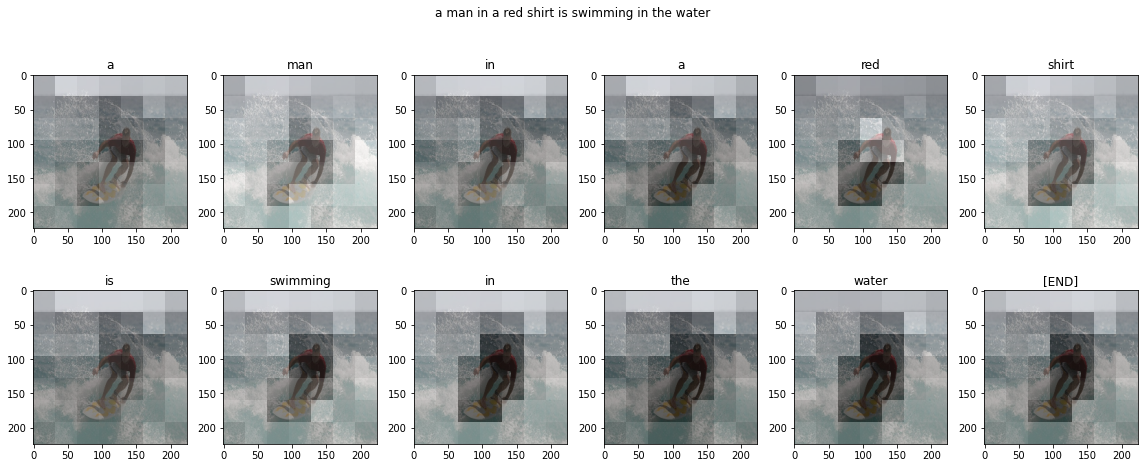

##### Dropout Rate: 0.2

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 23.123% (`t = 0`)
2. 19.578% (`t = 0.5`)
3. 7.660%  (`t = 1`)

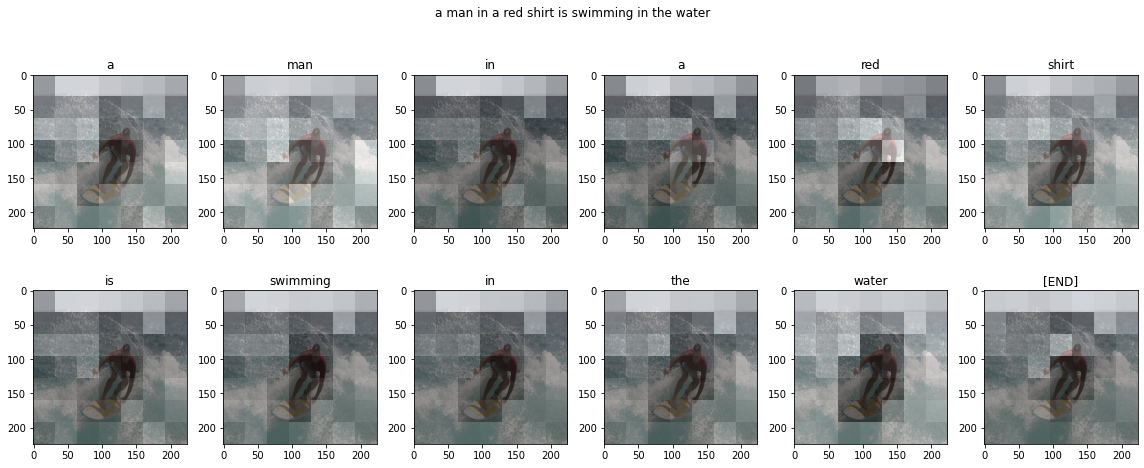

##### Dropout Rate: 0.3

Corpus BLEU (πρώτων 100 δειγμάτων του test set): 
1. 22.942% (`t = 0`)
2. 18.285% (`t = 0.5`)
3. 6.488%  (`t = 1`)

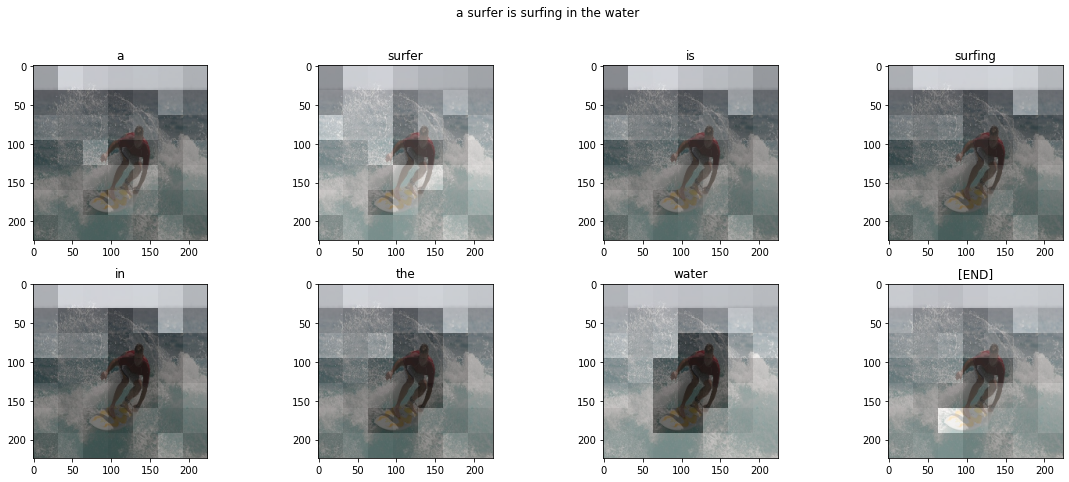

##### Συμπεράσματα

Παρατηρούμε πως η μείωση του dropout rate αυξάνει τα Corpus BLEU Scores κάτι που υποψιαζόμασταν. Όσον αφορά το Corpus BLEU, το dropout rate 0.2 μας δίνει τις καλύτερες τιμές. Για dropout rates μεγαλύτερα του 0.1, το attention φαίνεται να "βγάζει όλο και περισσότερο νόημα" στην εικόνα με τον surfer. Βλέπουμε πως για rate 0.3, όταν το δίκτυο αποφαίνεται στο token "surfer", το attention είναι στραμμένο σε αυτόν. Αντίστοιχα ισχύουν για το "water" (για το "water" & το "red" είναι επιτυχημένο και το attention στο dropout rate 0.2).

Στη δεύτερη άγνωστη εικόνα που δεν παραθέσαμε, τα rates 0.2, 0.3 απέδωσαν εξ'ίσου καλά (ίδιο caption) ενώ το rate 0.1 έδωσε υποδεέστερο caption, στο οποίο επαναλαμβάνονταν tokens.

 Με βάση τις παραπάνω παρατηρήσεις μπορούμε να καταλήξουμε σε dropout rate 0.2 ή 0.3. Επιλέγουμε τo 0.3, επειδή είναι πιο συμβατική τιμή, δεν απέχει όσον αφορά το Corpus BLEU πολύ από το "βέλτιστο", ενώ στο παραπάνω παράδειγμα το attention είναι πιο ξεκάθαρο και ερμηνεύσιμο. 

### Τελική Βελτιστοποίηση

Με βάση τη παραπάνω βελτιστοποίηση, έχουμε κατασταλλάξει στις εξής παραμέτρους:
1. `min_length=`6
2. `max_length=`33
3. `vocabulary_size=`$10κ$
4. `embeddings=`**`wiki300`** (αν χρησιμοποιήσουμε pretrained embeddings)
5. `beam_width=`3 (ή 5 σε κάποιες περιπτώσεις)
6. `dropout_rate=`0.3

Παρακάτω επιχειρούμε να βρούμε βέλτιστο συνδυασμό των υπολοιπόμενων παραμέτρων δηλαδή `encoder`, `units,` `num_heads`, `num_layers`.


#### Θεωρία

Παραθέτουμε για πληρότητα και καλύτερη κατανόηση της βελτιστοποίησης που καλούμαστε να πραγματοποίησουμε, θεωρητικές γνώσεις για τη δομή του decoder και κάποιων εκ των παραμέτρων που πρέπει να βελτιστοποιήσουμε.

##### `DecoderLayer`

Ο decoder μας αποτελείται από `num_layers` το πλήθος `DecoderLayer`s. Ένα `DecoderLayer` αποτελείται από 3 βασικά επίπεδα: 
- δύο multihead attention layers εκ των οποίων το ένα είναι αιτιατό επίπεδο self-attention και το άλλο όχι αιτιατό αλλά cross-attention
- ένα feed-forward επίπεδο 

Ακολουθεί `TokenOutput` Layer, το οποίο δέχεται την έξοδο του τελευταίου `DecoderLayer` και προσπαθεί να την ερμηνεύσει (με γραμμικό επίπεδο και κατάλληλη αρχικοποίηση στα biases) για να εξάγει logits, δηλαδή τον λογάριθμο της πιθανοφάνειας να είναι ένα εκ των tokens του vocabulary μας, το επόμενο στο παραγόμενο caption.

Ένα `DecoderLayer` δέχεται ως είσοδο ένα ζεύγος της μορφής `(image_features, caption)`. 

Το `caption` διέρχεται από το self-causal attention layer παράγοντας κάποιο value. Διαισθητικά μπορούμε να πούμε πως εξάγουμε πληροφορία από το caption η οποία να έχει σχέση με τα captions που έχουν παρατηρηθεί "ως τώρα". 

Χρησιμοποιούμε αυτή τη πληροφορία από το caption και τη "συγκρίνουμε" με χαρακτηριστικά της εικόνας που θέλουμε να παράξουμε το caption (cross-attention). Σε αυτό το βήμα δεν μας νοιάζει κάποιου είδους causality στο attention. Έχουμε κάποιες πληροφορίες για το μεχρι τώρα caption και διαθέσιμα τα χαρακτηριστικά "ολόκληρης" την εικόνας που προσπαθούμε να περιγράψουμε. Έτσι, δημιουργούμε μία (ενδίαμεση ενδεχομένως) latent αναπαράσταση που συνδυάζει "πληροφορία" από τα μέχρι τώρα tokens και τα χαρακτηριστικά της εικόνας που μας ενδιαφέρει. Την βάζουμε ως είσοδο στο feed-forward επίπεδο.


Το feed-forward επίπεδο αποτελείται από ένα πυκνό γραμμικό επίπεδο, με έξοδο μεγέθους `2*units`, ώστε να δέχεται την έξοδο του cross-attention layer, να τη φιλτράρει με μη-γραμμικότητα (`ReLU`). 

Παράγει έξοδο της οποίας θα ρίξει τη διαστατικότητα, με ένα δεύτερο γραμμικό επίπεδο χωρίς ενεργοποίηση, διάστασης `units`. Έτσι δημιουργείται αναπαράσταση που μπορεί να χρησιμοποιηθεί ή για τη πρόβλεψη του επόμενου token ή για να εισαχθεί σε επόμενο `DecoderLayer` για περαιτέρω επεξεργασία. 

Το layer αυτό αποτελείται και από dropout επίπεδο για regularization κατά την εκπαίδευση, όπως και `LayerNormalization`, ουσιαστικά standardization - per sample & όχι batch - που έχει παρατηρηθεί πως στη πράξη ευνοεί το backpropagation.

##### `num_heads` 

Για να καταλάβουμε τη χρησιμότητα των `num_heads`, πρέπει να κατανοήσουμε τι είναι το MultiHead Attention. Αντίστοιχα για να κατανοήσουμε τι είναι το MultiHead Attention, πρέπει να κατανοήσουμε τι είναι το Attention. (Δεν θα ασχοληθούμε με τη χρησιμότητα των positional embeddings σε ένα attention layer. Επίσης, θα περιοριστούμε **μόνο** στην εξήγηση του self-attention.)

Έστω πως έχουμε ακολουθία από διανύσματα $x_1,...,x_n$ (πχ. τα word + positional embeddings των tokens) και θέλουμε να την απεικονίσουμε σε μία ακολουθία διανυσμάτων εξόδου $y_1,...,y_n$. Μπορεί η τιμή $y_i$ να μην εξαρτάται μόνο από το $x_i$ (το ποια λέξη είναι πιο πιθανή να ακολουθήσει σε μία πρόταση εξαρτάται αρκετά από το context). 

Γι'αυτό, υποθέτουμε πως η τιμή $y_i$ προκύπτει ως σταθμισμένος γραμμικός συνδυασμός των $x_i$, δηλαδή $y_i=\sum_{j=1}^{n} a_{ij}\cdot x_j$, όπου $a_{ij}$ κάποιος συντελεστής βαρύτητας του πόσο σημαντική είναι η τιμή $x_j$ για τη διαμόρφωση του $x_i$. Τα $a_{ij}$ είναι θετικά και αθροίζουν στη μονάδα για κάθε $i$. 


*Αν για κάθε $i, y_i = \sum_{j=1}^{i} a_{ij}\cdot x_j$, τότε λέμε πως έχουμε causal self attention. (Δεν γίνεται η έξοδος να επηρεάζεται από "επόμενες" τιμές στην είσοδο.)*

Ορίζουμε κάποιες επιπλέον έννοιες:
- $score(x_i,x_j)$: ποσοτικοποίηση ομοιότητας των στοιχείων $x_i, x_j$.<br>
Με βάση το $score$ τα $a_{ij}$ υπολογίζονται ως $a_{ij} = softmax(score(x_i,x_j))$.
- $q_i = query(x_i)$: ειδική αναπαράσταση του token $x_i$, όταν θεωρείται η τρέχουσα είσοδος.
- $k_i = key(x_i)$: ειδική αναπαράσταση του token $x_i$, όταν **δεν** είναι η τρέχουσα είσοδος.
- $v_i = value(x_i)$: ειδική αναπαράσταση της εξόδου που θέλουμε να παράγει το μοντέλο, όταν το $x_i$ είναι η τρέχουσα είσοδος.

Τα διανύσματα query, key και value προκύπτουν από **εκπαιδεύσιμους** γραμμικούς μετασχηματισμούς των $x_i$.
Άπαξ και έχουμε τους μετασχηματισμούς αυτούς, μπορούμε να υπολογίσουμε την ομοιότητα στοιχείων με φόρμουλα της μορφής $score(x_i, x_j) = q_i \cdot k_j$. (Έχουμε υποθέσει πως το πρώτο όρισμα είναι το current token. Σαφώς το score αυτό **δεν** είναι συμμετρικό απαραίτητα.) 

Πλέον το $y_i$ υπολογίζεται ως  $y_i=\sum_{j=1}^{n} a_{ij}\cdot v_j$.

Βλέπουμε λοιπόν πως ένα attention head ουσιαστικά αποτελείται από τρεις εκπαιδεύσιμους πίνακες, οι οποίοι, με είσοδο ακολουθίες διανυσμάτων, δημιουργούν σταθμισμένους γραμμικούς συνδυασμούς που εξαρτώνται από την ομοιότητα του κάθε διανύσματος εισόδου με τη τρέχουσα είσοδο. 

Είναι δύσκολο με τρεις γραμμικούς μετασχηματισμούς να αποδώσουμε σύνθετες γλωσσικές συσχετίσεις (ή αντίστοιχα συσχετίσεις μεταξύ γλώσσας και εικόνων, στο cross-attention). Γι'αυτό, μπορούμε να χρησιμοποιήσουμε περισσότερα heads, δημιουργούντας παράλληλα περισσότερες ακολουθίες εξόδων. Ελπίζουμε ότι τα περισσότερα heads, θα εκμεταλλευτούν καλύτερα τις συσχετίσεις μεταξύ των δεδομένων εισόδου. Για μία "χρονική στιγμή", αυτοί οι όροι των διαφορετικών ακολουθιών εξόδου που παράγονται, γίνονται concatenated και projected κατάλληλα, μέσω γραμμικών επιπέδων, στη διάσταση εξόδου που μας ενδιαφέρει.

*Πηγή: Κεφάλαιο 10, Speech and Language Processing (3rd ed. draft), Dan Jurafsky and James H. Martin*

#### Δοκιμές

Παρακάτω δοκιμάζουμε τους encoders `MobileNetV3Small`, `EfficientNetV2Small`, `ConvNeXtBase`, `EfficientNetB0`, `EfficientNetB2`.

Για την επιλογή του encoder, επιλέξαμε και δοκιμάσαμε μερικά από τα μοντέλα που παρέχονται από το [keras.io/applications](https://keras.io/api/applications/).

Για την επιλογή των μοντέλων, αρχικά απορρίψαμε μοντέλα τα οποία είναι πολύ αργά (σύμφωνα με τις τιμές Time per inference step στον πίνακα του keras), καθώς αυτά θα καθυστερούσαν πολύ την εκπαίδευση. Απορρίψαμε επίσης μοντέλα τα οποία έχουν μεγάλο μέγεθος, ώστε να μην δεσμεύουν πολλούς πόρους, ενώ γενικά τα μεγάλα μοντέλα φαίνεται να είναι και πιο αργά. Από όσα μοντέλα απέμειναν επιλέξαμε κάποια που έχουν καλές τιμές του Top-1 Accuracy ή του Top-5 Accuracy.
Δοκιμάσαμε επίσης και το μοντέλο ConvNeXtBase, παρ'όλο που είναι μεγάλο σε μέγεθος και παίρνει πολύ χρόνο ανά inference step, καθώς έχει υψηλές τιμές accuracy.

Για τα μοντέλα που επιλέξαμε, δοκιμάζουμε διάφορες τιμές για τις παραμέτρους `num_heads` και `num_layers`. 
Επιλέγουμε να χρησιμοποιήσουμε για όλα τα μοντέλα τα pretrained embeddings από το `wiki300`, διότι θεωρήσαμε ότι έτσι η σύγκριση μεταξύ των μοντέλων θα είναι πιο αξιόπιστη (κοινός άξονας αναφοράς). Άρα παντού υποθέτουμε `units = 300`. 

Κατά την εκπαίδευση, όλα τα μοντέλα φαίνονταν να συγκλίνουν σε παρόμοιες τιμές loss και accuracy, επομένως δεν βασιστήκαμε σε αυτές τις μετρήσεις για την σύγκρισή τους. Αντίστοιχα, δεν μπορούμε να συγκρίνουμε εύκολα τον χρόνο εκπαίδευσης των μοντέλων, διότι το πλήθος των εποχών που χρειάζεται κάθε μοντέλο είναι διαφορετικό, ενώ διαφέρει ακόμα και μεταξύ εκτελέσεων για το ίδιο μοντέλο. 

Για την επιλογή του καλύτερου μοντέλου, βασιζόμαστε κυρίως στις τιμές του Corpus BLEU που μετράμε για τις πρώτες 100 εικόνες του test set. Κάθε φορά μετράμε το Corpus BLEU χρησιμοποιώντας θερμοκρασίες `0`, `0.5` και `1`, και στη συνέχεια χρησιμοποιώντας beam search, με `beam_width = 5`.

##### EfficientNetV2S

| Heads | Layers | Corpus BLEU (`t = 0`) | (`t = 0.5`) | (`t = 1`) | (`beam_width = 5`) |
|:-----:|:------:|:---------------------:|:-----------:|:---------:|:------------------:|
|   3	  |    2	 |        20.020%        |   18.177%   |   8.464%		|        23.219%
|   2   |    3   |        22.560%        |   19.160%   |   6.828%  |       24.524%      |
|   3   |    3   |        21.187%        |   17.766%   |   8.352%  |       22.030%      |
|   2   |    4   |        22.678%        |   17.910%   |   7.998%  |       22.569%      |
|   4   |    2   |        23.943%        |   19.242%   |   6.826%  |       26.756%      |

##### ConvNeXtBase


| Heads | Layers | Corpus BLEU (`t = 0`) | (`t = 0.5`) | (`t = 1`) | (`beam_width = 5`) |
|:-----:|:------:|:---------------------:|:-----------:|:---------:|:------------------:|
|   2   |    2   |        28.454%        |   24.529%   |   9.415%  |       29.274%      |
|   4   |    2   |        30.944%        |   22.829%   |  12.118%  |       28.888%      |


*Σημείωση: Για το `ConvNeXtBase` οι δοκιμές ήταν περιορισμένες, διότι η εκτέλεση του κώδικα με χρήση αυτού του μοντέλου ήταν πολύ αργή.*

##### EfficientNetB0

| Heads | Layers | Corpus BLEU (`t = 0`) | (`t = 0.5`) | (`t = 1`) | (`beam_width = 5`) |
|:-----:|:------:|:---------------------:|:-----------:|:---------:|:------------------:|
|   2   |    2   |        22.446%        |   17.664%   |   4.415%  |       23.105%      |
|   2   |    3   |        24.156%        |   19.672%   |   7.676%  |       24.332%      |
|   3   |    2   |        23.670%        |   16.879%   |   8.290%  |       23.131%      |
|   3   |    3   |        20.096%        |   21.471%   |   7.385%  |       22.346%      |
|   2   |    4   |        24.019%        |   20.905%   |   8.695%  |       26.689%      |

##### EfficientNetB2

| Heads | Layers | Corpus BLEU (`t = 0`) | (`t = 0.5`) | (`t = 1`) | (`beam_width = 5`) |
|:-----:|:------:|:---------------------:|:-----------:|:---------:|:------------------:|
|   2   |    2   |        22.117%        |   18.014%   |   8.235%  |       22.890%      |
|   2   |    3   |        25.951%        |   19.088%   |   8.697%  |       25.096%      |
|   3   |    2   |        22.393%        |   19.559%   |   8.493%  |       25.794%      |
|   3   |    3   |        23.406%        |   19.517%   |   8.021%  |       22.664%      |
|   3   |    4   |        20.630%        |   18.849%   |   8.726%  |       22.741%      |

##### Συμπεράσματα

Από τις παραπάνω μετρήσεις, δίνουμε κυρίως βάρος στην καλύτερη τιμή από τις τρεις με χρήση θερμοκρασίας, και στις τιμές που προκύπτουν με beam search.
Βλέπουμε ότι το `ConvNeXtBase` για `num_heads = 2` και `num_layers = 2` έχει τις καλύτερες τιμές. Ωστόσο η εκτέλεσή του ήταν πολύ αργή, οπότε διακρίνουμε μεταξύ των υπολοίπων και το `EfficientNetB0` με `num_heads = 2` και `num_layers = 4`. Αυτό το μοντέλο είχε αρκετά καλά αποτελέσματα, κυρίως με χρήση beam search, αλλά και για `temperature = 0`, ενώ λόγω του μικρού μεγέθους του, η εκτέλεση του ήταν αρκετά πιο γρήγορη.


Παρατηρούμε πως η αύξηση στο πλήθος των heads δεν αυξάνει μονότονα το Corpus BLEU. Η αλόγιστη αύξηση του πλήθος των heads ενδεχομένως να "αναγκάσει" τα attention layers, να επικεντρωθούν σε λεπτομέρειες της εικόνας, οδηγώντας το μοντέλο μας σε overfit. Αντίστοιχα, η αύξηση του πλήθους των heads, αναγκάζει το attention layer να κάνει project ενός πολύ μεγάλου concatenated διανύσματος (το concatenation των εξόδων των heads). Το projection αυτό ενδεχομένως να μην είναι επιτυχημένο και να αλλοιώνει πληροφορία που ίσως να γινόταν extract καλύτερα με λιγότερα heads.

#### Τελικό Μοντέλο

Καταλήγουμε σε decoder ο οποίος χρησιμοποιεί beam search με `beam_width` 5 (Η' 3 αν μας ενδιαφέρει η ταχύτητα. Αν μας ενδιαφέρει κυρίως η ταχύτητα, τότε είναι βιώσιμη επιλογή και το greedy decoding). Πιο αναλυτικά, οι παράμετροι που καταλήγουμε είναι οι παρακάτω:


<u>*Βέλτιστο (αλλά αργό) μοντέλο*</u>
1. `encoder`=`ConvNeXtBase` 
2. `min_length=`6
3. `max_length=`33
4. `vocabulary_size=`$10κ$
5. `embeddings=`**`wiki300`** 
6. `beam_width=`5
7. `units` = 300 (λόγω των pretrained embeddings)
8. `dropout_rate=`0.3
9. `num_heads`=2
10. `num_layers`=2


<u>*Ικανοποιητικό μοντέλο*</u>
1. `encoder`=`EfficientNetB0` 
2. `min_length=`6
3. `max_length=`33
4. `vocabulary_size=`$10κ$
5. `embeddings=`**`wiki300`** 
6. `beam_width=`5
7. `units` = 300 (λόγω των pretrained embeddings)
8. `dropout_rate=`0.3
9. `num_heads`=2
10. `num_layers`=4

#### Μεμονωμένα Παραδείγματα

Μερικά ενδεικτικά captions που παράγουν τα δύο μοντέλα φαίνονται στη συνέχεια. Η εικόνα `888`, η `777` που έχει έναν πολύχρωμο τοίχο και η `2222` που το βασικό πράγμα που δείχνει είναι ένα μωρό αποτελούν δύσκολα δείγματα. Σε αυτές τις εικόνες τα μοντέλα δεν παράγουν ικανοποιητικό caption. Οι υπόλοιπες εικόνες αποτελούν ενδείξεις επιτυχίας του μοντέλου.

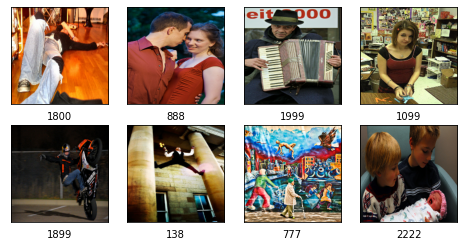

Αποτελέσματα του βέλτιστου μοντέλου:


```
ID: 1800
Hypothesis:	man in a blue jeans and blue jeans sits in front of a wall
References:
['A woman with ripped jeans is laying on the ground with her forearm over her face .', 'A person in ripped jeans and a black shirt lies on his back on a hardwood floor .', 'Man lays prostrate on the ground on his back possibly in exhaustion .', 'Person in ripped blue jeans lies on the hardwood floor .', 'Person with torn jeans laying down on a wood floor .']
Sentence Bleu:	9.749%
```
```
ID: 888
Hypothesis:	man in a red shirt and a man in a red shirt and a red shirt and a man in a red shirt
References:
['A young couple dressed in matching red outfits performing a romantic dance .', 'A man embracing a woman , both are wearing red outfits .', 'A young man and woman , both in red , hold each other .', 'A man and a woman wearing red embracing .', 'A man and woman are dancing closely .']
Sentence Bleu:	4.341%
``` 

```
ID: 1999
Hypothesis:	elderly man is playing an accordion
References:
['There is a man with a fedora hat and blue dress coat playing an accordion in front of a sign .', 'A man in a black cap and blue coat is playing the accordion while sitting down .', 'Adult man in a Black hat and coat playing an accordion by hand outside .', 'A middle-aged man wearing a Pandora hat is playing an old accordion .', 'A man in a black hat with a green stripe plays the accordion .']
Sentence Bleu:	18.179%
```
```
ID: 1099
Hypothesis:	young girl in a red shirt is standing in front of a store
References:
['A brown-haired girl in a maroon top is holding several blue strips of paper .', 'A teenage girl in a red shirt doing arts and crafts .', 'A girl in a red top is holding slips of paper .', 'A girl in a red tank top using colored labels .', 'A girl in red dividing colored tabs .']
Sentence Bleu:	34.132%
```

``` 
ID: 1899
Hypothesis:	man in a black helmet is riding a motorcycle on a motorcycle
References:
['A man in a black and red jacket and helmet does a stunt on a motorbike .', 'A person performing a wheelie trick on a motorcycle in a parking lot .', 'A man standing on a motorcycle doing a stunt', 'Motorcycle daredevil on reared motorcycle .', 'Someone riding sideways on a motorcycle .']
Sentence Bleu:	42.600%
```
``` 
ID: 138
Hypothesis:	man in a black shirt and black pants is jumping in front of a building
References:
['Man in black pants and vest balances between to pillars , holding two flaming torches in his right hand .', 'A well-dressed man climbing between two columns while holding torches .', 'A man in a suit is straddling two pillars while holding a flame .', 'juggler standing balanced between two columns', 'man scaling wall with fire in hand']
Sentence Bleu:	19.048%
```

``` 
ID: 777
Hypothesis:	man in a blue shirt is walking down the sidewalk
References:
['A painting of a city with a old person with a walker , some people running , a person with a grocery cart , bald eagle in the sky , and a person floating above the ground .', 'A older man with a walker walking in front of a colorful wall , with multiple things going on it .', 'A man with a walker walking on the sidewalk in front of a mural of different things painted .', 'a mural with vivid colors and people of various ages is displayed .', 'Woman in green cap walks in front of city mural .']
Sentence Bleu:	12.208%
```
``` 
ID: 2222
Hypothesis:	young boys are playing in a car
References:
['Two teenage helping their mother to carry their small brother after their mother received a phone call .', 'Two children in sweaters are holding a baby wrapped in a blanket that is crying .', 'Two young boys hold a crying infant while both are sitting in the same chair .', 'Two young children sitting in a blue chair holding a newborn baby .', 'Two young children are holding a baby .']
Sentence Bleu:	19.880%
```

Αποτελέσματα του ικανοποιητικού μοντέλου:


```
ID: 1800
Hypothesis:	young man in a blue shirt is sitting on a couch
References:
['A woman with ripped jeans is laying on the ground with her forearm over her face .', 'A person in ripped jeans and a black shirt lies on his back on a hardwood floor .', 'Man lays prostrate on the ground on his back possibly in exhaustion .', 'Person in ripped blue jeans lies on the hardwood floor .', 'Person with torn jeans laying down on a wood floor .']
Sentence Bleu:	10.973%
```
```
ID: 888
Hypothesis:	man in a red shirt and a woman in a red shirt and a woman in a red shirt is standing in front of a crowd
References:
['A young couple dressed in matching red outfits performing a romantic dance .', 'A man embracing a woman , both are wearing red outfits .', 'A young man and woman , both in red , hold each other .', 'A man and a woman wearing red embracing .', 'A man and woman are dancing closely .']
Sentence Bleu:	8.016%
```




```
ID: 1999
Hypothesis:	man in a black shirt is playing a guitar
References:
['There is a man with a fedora hat and blue dress coat playing an accordion in front of a sign .', 'A man in a black cap and blue coat is playing the accordion while sitting down .', 'Adult man in a Black hat and coat playing an accordion by hand outside .', 'A middle-aged man wearing a Pandora hat is playing an old accordion .', 'A man in a black hat with a green stripe plays the accordion .']
Sentence Bleu:	34.248%
```
```
ID: 1099
Hypothesis:	woman in a black shirt is sitting at a table
References:
['A brown-haired girl in a maroon top is holding several blue strips of paper .', 'A teenage girl in a red shirt doing arts and crafts .', 'A girl in a red top is holding slips of paper .', 'A girl in a red tank top using colored labels .', 'A girl in red dividing colored tabs .']
Sentence Bleu:	9.759%
```

```
ID: 1899
Hypothesis:	man wearing a helmet is riding a bike
References:
['A man in a black and red jacket and helmet does a stunt on a motorbike .', 'A person performing a wheelie trick on a motorcycle in a parking lot .', 'A man standing on a motorcycle doing a stunt', 'Motorcycle daredevil on reared motorcycle .', 'Someone riding sideways on a motorcycle .']
Sentence Bleu:	6.095%
```
```
ID: 138
Hypothesis:	man in a black shirt is standing in front of a building
References:
['Man in black pants and vest balances between to pillars , holding two flaming torches in his right hand .', 'A well-dressed man climbing between two columns while holding torches .', 'A man in a suit is straddling two pillars while holding a flame .', 'juggler standing balanced between two columns', 'man scaling wall with fire in hand']
Sentence Bleu:	18.873%
```

```
ID: 777
Hypothesis:	group of people are standing in front of a crowd
References:
['A painting of a city with a old person with a walker , some people running , a person with a grocery cart , bald eagle in the sky , and a person floating above the ground .', 'A older man with a walker walking in front of a colorful wall , with multiple things going on it .', 'A man with a walker walking on the sidewalk in front of a mural of different things painted .', 'a mural with vivid colors and people of various ages is displayed .', 'Woman in green cap walks in front of city mural .']
Sentence Bleu:	36.577%
```
```
ID: 2222
Hypothesis:	little boy is sitting on a couch
References:
['Two teenage helping their mother to carry their small brother after their mother received a phone call .', 'Two children in sweaters are holding a baby wrapped in a blanket that is crying .', 'Two young boys hold a crying infant while both are sitting in the same chair .', 'Two young children sitting in a blue chair holding a newborn baby .', 'Two young children are holding a baby .']
Sentence Bleu:	6.597%
```

### Υποβολή

In [ ]:
# Download competition files list
competition_files_list = tf.keras.utils.get_file('competition_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/competition_files.csv',
                                           extract=False)

path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)

competition_files = (path/competition_files_list).read_text().splitlines()
competition_files = [str(path/IMAGE_DIR/fname) for fname in competition_files]

In [ ]:
test_hypotheses = list()
for image_path in competition_files:
    image = load_image(image_path)
    caption = model.simple_gen(image, beam_search = True, beam_width = 5) 
    test_hypotheses.append(caption.split())

In [ ]:
jsonString = json.dumps(test_hypotheses)
jsonFile = open("test_hypotheses.json", "w")
jsonFile.write(jsonString)
jsonFile.close()